In [ ]:
# default_exp exposure
%reload_ext autoreload
%autoreload 2
from nbdev.showdoc import show_doc
# for testing


import pickle
import matplotlib.pyplot as plt
!date

Fri Jul 30 06:22:21 PDT 2021


# Exposure processing
> Process FT2 exposure information for a source direction 

In [ ]:
#export
import pandas as pd
import numpy as np

from wtlike.config import (Config, UTC, MJD)
from wtlike.effective_area import EffectiveArea

In [ ]:
# export
def _sc_process(config, source, sc_data):
    
    """
    
    - sec_data -- DF constructedted from FT2.
    
    
    Return: a DF with the S/C data for the source direction, wtih cos theta and zenith cuts
    
    columns:
    - start, stop, livetime -- from the FT2 info
    - cos_theta -- angle between bore and direction 
    """
    
    # calculate cosines with respect to sky direction
    ra_r,dec_r = np.radians(source.ra), np.radians(source.dec)
    sdec, cdec = np.sin(dec_r), np.cos(dec_r)

    def cosines( ra2, dec2):
        ra2_r =  np.radians(ra2.values)
        dec2_r = np.radians(dec2.values)
        return np.cos(dec2_r)*cdec*np.cos(ra_r-ra2_r) + np.sin(dec2_r)*sdec

    cos_thetas = cosines(sc_data.ra_scz,    sc_data.dec_scz)
    zcosines = cosines(sc_data.ra_zenith, sc_data.dec_zenith)
    # mask out entries too close to zenith, or too far away from ROI center
    mask =   (cos_thetas >= config.cos_theta_max) & (zcosines>=np.cos(np.radians(config.z_max)))
    if config.verbose>1:
        print(f'\tFound {len(mask):,} S/C entries:  {sum(mask):,} remain after zenith and theta cuts')
    dfm = sc_data.loc[mask,:]
    livetime = dfm.livetime.values
    
    #return livetime, cos_thetas[mask]

    return  pd.DataFrame(
        dict(
            start=sc_data.start[mask],
            stop=sc_data.stop[mask],
            livetime=livetime,
            cos_theta=cos_thetas[mask],
        )
    )

In [ ]:
# export
from abc import abstractmethod

class BaseExposure(object):
    """
    Base class for implementing exposure calculation
    """
    
    def __init__(self, config, source):
        
        self.config = config
        self.source = source
        self.Aeff = EffectiveArea(file_path=config.wtlike_data/'aeff_files')
        self.setup()
    
    @abstractmethod
    def setup(self):
        pass
            
    def __call__(self, cos_theta) : #sc_data):
        """
        Apply to a SC data set
        - cos_theta -- array of cos(theta) values
        
        Returns:
        
        array of the weighted effective area
        
        """
        # as set by self.setup -- also serl.back_min
        edom = self.edom
        wts = self.wts #self(edom)

        # a table of the weights for each pair in livetime and cos_theta arrays
        rvals = np.empty([len(wts),len(cos_theta)])
        
        for i, (en,wt) in enumerate(zip(edom,wts)):
            faeff, baeff = np.array(self.Aeff( [en], cos_theta ))
            if en>self.back_min:
                rvals[i] = (faeff+baeff)*wt # note that adds front and back exposure
            else:
                rvals[i] = faeff * wt # only front

        from scipy.integrate import simpson
        aeff = simpson(rvals, edom,axis=0) / simpson(wts,edom)

        return aeff
    
class KerrExposure(BaseExposure):
    """
    """
    
    bins_per_decade: int=5
    base_spectrum: str='lambda E: (E/1000)**-2.1'
    energy_range: tuple = (100.,1e6)

    
    def setup(self ):
        
        """set up energy domain, evaluate fluxes
           This is the Kerr version, with wired-in values 
        """
        
        emin,emax = self.energy_range
        loge1=np.log10(emin); loge2=np.log10(emax)
        self.edom= np.logspace(loge1, loge2, int((loge2-loge1)*self.bins_per_decade+1))
        
        spectrum = eval(self.base_spectrum) #lambda E: (E/1000)**-2.1
       
        self.wts = spectrum(self.edom)

        # the threshold for including Back events
        self.back_min=0

In [ ]:
# export
class SourceExposure(BaseExposure):
    """
    BaseExposure subclass that uses the source spectrum applied only to used bands 
    """
    
    def setup(self):
        # set up weighted exposure using bands actually used, and actual flux
        
        wtdict = self.source.wtman.wt_dict
        bandids = np.array(list(wtdict.keys()))

        self.wts = np.array([wtdict[key]['flux'] for key in bandids if key%2==0])
        self.edom = self.config.energy_bins[:len(self.wts)]
        self.back_min = 300 # wired in--should check?
        
        if self.config.verbose>1:
            print(f'Set up flux-weigted exposure for {self.source.name}')

In [ ]:
# export  
def time_bin_edges(config, exposure, tbin=None):
    """Return an interleaved array of start/stop values

    tbin: an array (a,b,d), default config.time_bins

    interpretation of a, b:

        if > 50000, interpret as MJD
        if <0, back from stop
        otherwise, offset from start

    d : if positive, the day bin size
        if 0; return contiguous bins


    """
    # nominal total range, MJD edges
    start = np.round(exposure.start.values[0])
    stop =  np.round(exposure.stop.values[-1])

    a, b, step = tbin if tbin is not None else config.time_bins


    if a>50000: start=a
    elif a<0: start = stop+a
    else : start += a


    if b>50000: stop=b
    elif b>0: stop = start+b
    else: stop += b

    if step<=0:
        return contiguous_bins(exposure.query(f'{start}<start<{stop}'),)

    # adjust stop
    nbins = int((stop-start)/step)
    assert nbins>0, 'Bad binning: no bins'
    stop = start+(nbins)*step
    u =  np.linspace(start,stop, nbins+1 )

    # make an interleaved start/stop array
    v = np.empty(2*nbins, float)
    v[0::2] = u[:-1]
    v[1::2] = u[1:]
    return v


In [ ]:
# export
def sc_data_selection(config, source, sc_data):
    
    """
    Return a DF with the S/C data for the source direction, wtih cos theta and zenith cuts
    
    columns:
    - start, stop, livetime -- from the FT2 info
    - cos_theta -- angle between bore and direction 
    - exp -- effective area at angle wighted by a default spectral function, times livetime
 
    """
    
    sc_df = _sc_process(config, source, sc_data)
    cos_theta = sc_df.cos_theta.values
    livetime = sc_df.livetime.values

    # now get appropriate weighted effective area, mjultipy by livetime
    if config.use_kerr:
        sc_df.loc[:,'exp'] = KerrExposure(config, source)(cos_theta) * livetime
    else:
        sc_df.loc[:,'exp']= SourceExposure(config, source)(cos_theta) * livetime
    
    return sc_df


In [ ]:
# export
def binned_exposure(config, exposure, time_edges):
    """Bin the exposure in to cells

    - exposure -- A DataFrame derived from FT2
    - time_bins: list of edges, an interleaved start/stop array


    Returns:
    
    An array of exposure integrated over each time bin. Assumes that the time bins 
    are contained within the exposure.
    
    it is interleaved, client must apply [0::2] selection. (why not do it here?)

    """

    # get exposure calculation
    exp   =exposure.exp.values
    estart= exposure.start.values
    estop = exposure.stop.values

    # determine bins,

    #use cumulative exposure to integrate over larger periods
    cumexp = np.concatenate(([0],np.cumsum(exp)) )

    # get index into tstop array of the bin edges
    edge_index = np.searchsorted(estop, time_edges)

    # return the exposure integrated over the intervals
    cum = cumexp[edge_index]

    # difference is exposure per interval
    bexp = np.diff(cum)
#     if config.verbose>1:
#         print(f'exposure per bin:\n{pd.Series(bexp).describe(percentiles=[])}')
    return bexp

In [ ]:
show_doc(time_bin_edges)

show_doc(binned_exposure)

<h4 id="time_bin_edges" class="doc_header"><code>time_bin_edges</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>time_bin_edges</code>(**`config`**, **`exposure`**, **`tbin`**=*`None`*)

Return an interleaved array of start/stop values

tbin: an array (a,b,d), default config.time_bins

interpretation of a, b:

    if > 50000, interpret as MJD
    if <0, back from stop
    otherwise, offset from start

d : if positive, the day bin size
    if 0; return contiguous bins

<h4 id="binned_exposure" class="doc_header"><code>binned_exposure</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>binned_exposure</code>(**`config`**, **`exposure`**, **`time_edges`**)

Bin the exposure in to cells

- exposure -- A DataFrame derived from FT2
- time_bins: list of edges, an interleaved start/stop array


Returns:

An array of exposure integrated over each time bin. Assumes that the time bins 
are contained within the exposure.

it is interleaved, client must apply [0::2] selection. (why not do it here?)

### Test with a Geminga week

First use old method to generate 

In [ ]:
#hide
config=Config(use_kerr=True); 
if config.valid:
    config.verbose=2
    week_no = 10

    from wtlike.sources import PointSource
    from wtlike.load_data import get_week_files
    source =PointSource('Geminga', config=config) 
    print(f'Get  week # {week_no} for {source.name}')
    week_files = get_week_files(config, (week_no,week_no)); 
    week_file = week_files[0]

    sc_data =  pickle.load(open(week_file, 'rb'))['sc_data']

    # determine weighed exposure DF
    src_exp = sc_data_selection(config, source, sc_data)
    print(src_exp.head())

#         edges = time_bin_edges(config, src_exp, (0,0,1/24))

#         fig,ax = plt.subplots(figsize=(12,3))
#         ax.plot(edges[0::2]-edges[0], binned_exposure(config, src_exp, edges )[::2]/1e6,'+');
#  v       ax.set(xlabel=f'day of week {week_no}', ylabel='hourly exposure');
    print(f'\nExposure description, with use_kerr={config.use_kerr}\n{src_exp.exp.describe()}')

WeightMan: file from source "Geminga"_weights.pkl : 16 bamds with nsides 64 to 512
Get  week # 10 for Geminga
LoadData: Loading weeks[10:10:]
	Found 16,826 S/C entries:  5,633 remain after zenith and theta cuts
       start      stop  livetime  cos_theta       exp
53  54685.17  54685.17     27.45       0.42  35034.11
54  54685.17  54685.17     27.46       0.44  39596.63
55  54685.17  54685.17     27.50       0.46  44258.90
56  54685.17  54685.17     27.52       0.48  48795.06
57  54685.17  54685.17     27.53       0.50  53288.60

Exposure description, with use_kerr=True
count      5633.00
mean      89305.61
std       33910.22
min        1117.04
25%       60491.62
50%       87129.21
75%      124531.16
max      151232.82
Name: exp, dtype: float64


### Saved output for comparison
```
	Found 16,826 S/C entries:  5,633 remain after zenith and theta cuts
count      5633.00
mean      89305.61
std       33910.22
min        1117.04
25%       60491.62
50%       87129.21
75%      124531.16
max      151232.82
dtype: float64
```

### Check flux values per energy band from weight computation 
Compare with default

   band      flux  energy   eflux
0     0  1.22e-08  133.35  216.64
1     2  6.08e-09  237.14  342.00
2     4  2.85e-09  421.70  506.10
3     5  2.85e-09  421.70  506.10
4     6  1.21e-09  749.89  680.98 



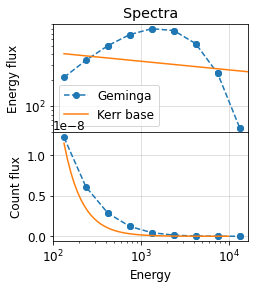

In [ ]:
#hide
if config.valid:
    # make a DF with spectrum
    wtdict = source.wtman.wt_dict

    bf_df = pd.DataFrame(dict(
        band=wtdict.keys(), flux=[d['flux'] for d in wtdict.values()]))
    bf_df.loc[:,'energy'] = config.energy_bins[bf_df.band//2]
    bf_df.loc[:,'eflux'] = (bf_df.flux * bf_df.energy**2)*1e6
    print(bf_df.head(), '\n')


    plt.rc('font', size=12)
    fig, (ax,ax2) =plt.subplots(2,1, figsize=(3.5,4), sharex=True)
    plt.subplots_adjust(hspace=0)
    ax.loglog('energy', 'eflux', 'o--',data=bf_df,label=f'{source.name}'); ax.grid(alpha=0.5)
    ax.set(xlabel='Energy', ylabel='Energy flux',  xlim=(100,None), title='Spectra');
    base_spectrum = eval(KerrExposure.base_spectrum)
    edom = config.energy_bins[:12]
    ax.loglog(edom, base_spectrum(edom)*edom**2/3e3, '-' , label='Kerr base')
    ax.legend();
    ax2.plot('energy', 'flux', 'o--',data=bf_df,label=f'{source.name}'); ax2.grid(alpha=0.5)
    edom2 = np.logspace(2.125,4)
    ax2.plot(edom2, base_spectrum(edom2)/6e9, '-' , label='Kerr base')
    ax2.set(xlabel='Energy', ylabel='Count flux');


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_exposure.ipynb.
Converted 03_sources.ipynb.
Converted 04_load_data.ipynb.
Converted 04_simulation.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Fri Jul 30 06:22:25 PDT 2021
